In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
%matplotlib inline

from keras.layers import Input,Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import np_utils
from keras import backend as K


# Data Visualization

** Distribution to identify whether data is balanced or unbalanced**


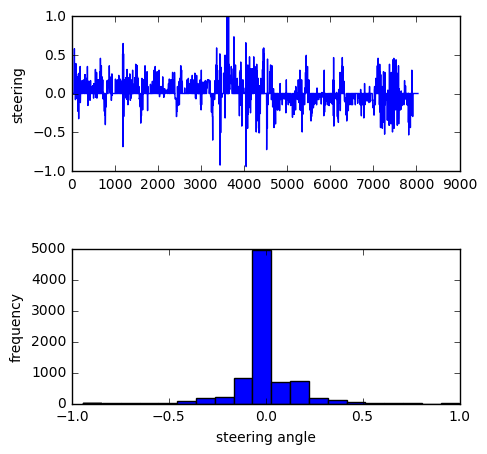

straight_steers:4361        left_steers:1775     right_steers:1900       Total samples:8036


In [3]:
### This project is about predicting steering angle from center camera image given as input.
### The approach used to solve this problem is End to End learning using DNN.Since prediction of steering angle is 
### continuous , it is a regression problem.


df = pd.read_csv('./data/data/driving_log.csv')
fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(hspace=0.5)
fig.add_subplot(2,1,1)
plt.plot(df.steering)
plt.ylabel('steering')
fig.add_subplot(2,1,2)
plt.hist(df.steering,bins=20)
plt.xlabel('steering angle')
plt.ylabel('frequency')
plt.show()

straight_steers=len(df[df.steering==0.0])
left_steers=len(df[df.steering<0.0])
right_steers= len(df[df.steering>0.0])

print("straight_steers:{0}        left_steers:{1}     right_steers:{2}       Total samples:{3}"
      .format(straight_steers,left_steers, right_steers,len(df.steering)))


** Inference from the above is eventhough left angle and right angle data are equally distributed,the straight angle data are almost 50% of total data. This may result in prediction biased towards straight steering.EIther reduction of straight angle data is one of approach to create balanced data or increasing the non zero steering inputs by augmentation using flipping,recovery data, brightness etc.**

# All 3 camera images visualization 

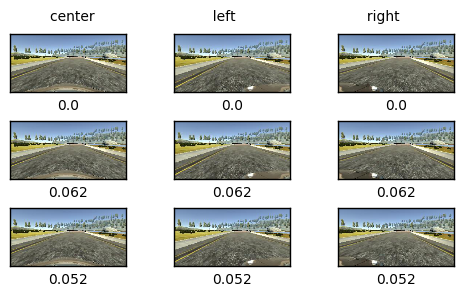

In [4]:
import os

path = './data/data/'

fig = plt.figure(figsize=(6,3))
fig.subplots_adjust(hspace=0.5)
i=1
for index in range(50,53):
    for image_name in (df.center[index],df.left[index],df.right[index]):
        img = mpimg.imread(path + image_name.strip())
        ax = fig.add_subplot(3,3,i)
        ax.set_xlabel(round(df.steering[index],3))
        fig.suptitle('center                           left                              right')
        plt.imshow(img)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for tic in ax.xaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False
        for tic in ax.yaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False
            
        i=i+1
plt.show()

# Data stored as pickled file

The images are of resolution 320x160
In order to run training and inference phase on CPU, and also the DNN need to extract features(the road) only in high level, considered resizing to 32x16 and storing as pickled file.

# DO NOT RUN if already data is pickled
import pickle

file_Name = "training_dataset_resized.p"
# open the file for writing
fb = open(file_Name,'wb') 

img_path = './data/data/'

X_train_center=[]
y_train_center=[]

X_train_left=[]
y_train_left=[]

X_train_right=[]
y_train_right=[]

i=1

for index in range(0,len(df.steering)):

    img = mpimg.imread(path + df.center[index].strip())
    img = cv2.resize(img,(32,16))
    X_train_center.append(img)
        
    img = mpimg.imread(path + df.left[index].strip())
    img = cv2.resize(img,(32,16))
    X_train_left.append(img)
        
    img = mpimg.imread(path + df.right[index].strip())
    img = cv2.resize(img,(32,16))
    X_train_right.append(img)
        
    y_train_center.append(df.steering[index])
    y_train_left.append(df.steering[index])
    y_train_right.append(df.steering[index])
        
        
pickle.dump({'center': [X_train_center,y_train_center],'left':[X_train_left,y_train_left],
             'right': [X_train_right, y_train_right]},fb)
             
fb.close()


# Load from pickled file

In [5]:
import os
import pickle
import random

path = './data/data/'

file_Name = "training_dataset_resized.p"
with open(file_Name, mode='rb') as f:
    train_pickle = pickle.load(f)


X_train_center,y_train_center = train_pickle['center']
X_train_left,y_train_left = train_pickle['left']
X_train_right,y_train_right = train_pickle['right']

#  Should pass these tests which verifies pickled data is loaded correctly. 
assert np.array_equal(X_train_center, train_pickle['center'][0]), 'X_train not set to data[\'center\'].'
assert np.array_equal(y_train_center,  train_pickle['center'][1]), 'y_train not set to data[\'center\'].'
assert np.array_equal(X_train_left, train_pickle['left'][0]), 'X_train not set to data[\'left\'].'
assert np.array_equal(y_train_left,  train_pickle['left'][1]), 'y_train not set to data[\'left\'].'
assert np.array_equal(X_train_right, train_pickle['right'][0]), 'X_train not set to data[\'right\'].'
assert np.array_equal(y_train_right,  train_pickle['right'][1]), 'y_train not set to data[\'right\'].'
print('Tests passed.')

X_train_center = np.array(X_train_center)
y_train_center = np.array(y_train_center)
X_train_left = np.array(X_train_left)
y_train_left = np.array(y_train_left)
X_train_right = np.array(X_train_right)
y_train_right = np.array(y_train_right)

print("dimension of X_train_center:{}".format(X_train_center.shape))
print("dimension of y_train_center:{}".format(y_train_center.shape))
print("dimension of X_train_left:{}".format(X_train_left.shape))
print("dimension of y_train_left:{}".format(y_train_left.shape))
print("dimension of X_train_right:{}".format(X_train_right.shape))
print("dimension of y_train_right:{}".format(y_train_right.shape))


Tests passed.
dimension of X_train_center:(8036, 16, 32, 3)
dimension of y_train_center:(8036,)
dimension of X_train_left:(8036, 16, 32, 3)
dimension of y_train_left:(8036,)
dimension of X_train_right:(8036, 16, 32, 3)
dimension of y_train_right:(8036,)


# Visualizing loaded data

** Check the loaded data from pickled file and original image folder are same **

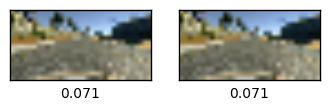

In [7]:
figure = plt.figure(figsize=(4,4))
fig.subplots_adjust(hspace=1.0)
ax=figure.add_subplot(1,2,1)
index = random.randint(0,len(y_train_center))

ax.set_xlabel(round(y_train_center[index],3))
plt.imshow(X_train_center[index])
for tic in ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False
for tic in ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False    

img = mpimg.imread(path + df.center[index].strip())
img = cv2.resize(img,(32,16))
ax=figure.add_subplot(1,2,2)
ax.set_xlabel(round(df.steering[index],3))
plt.imshow(img)
ax.set_yticklabels([])
ax.set_xticklabels([])
for tic in ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False
for tic in ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False    


# Recovery data augmentaion
### The data are generated to train the model so that car can recover when gets off to the side of the road. Left and Right camera images are used. 

    i) For left camera images, add offset to steering (addition due to steering should be turned to right side to recover)
    ii) For right camera images, subtract offset to steering (subtraction due to steering should be turned to left side to
        recover)
    iii) An offset of 0.25 choosen since it helped in recovering during steep left and right turns

In [8]:
def recovery_data(camera,offset,Y):
    if camera == 'left':
        Y +=offset
    elif camera == 'right':
        Y -=offset
    return Y

In [9]:
y_train_left = recovery_data('left',0.25,y_train_left)
y_train_right = recovery_data('right',0.25,y_train_right)
print(y_train_left[0:60])
print(y_train_right[0:60])

[ 0.25        0.25        0.25        0.25        0.25        0.25        0.25
  0.25        0.25        0.25        0.25        0.25        0.25        0.25
  0.25        0.25        0.25        0.25        0.25        0.25        0.25
  0.25        0.25        0.25        0.25        0.25        0.25        0.25
  0.25        0.25        0.25        0.25        0.25        0.25        0.25
  0.25        0.25        0.25        0.25        0.25        0.25        0.25
  0.25        0.25        0.25        0.25        0.25        0.25        0.25
  0.25        0.25        0.3117599   0.30219137  0.30219137  0.6179529
  0.8284606   0.8284606   0.4170138   0.25        0.25      ]
[-0.25       -0.25       -0.25       -0.25       -0.25       -0.25       -0.25
 -0.25       -0.25       -0.25       -0.25       -0.25       -0.25       -0.25
 -0.25       -0.25       -0.25       -0.25       -0.25       -0.25       -0.25
 -0.25       -0.25       -0.25       -0.25       -0.25       -0.25       -0.

# Flipping the Center Camera image
** It makes model robust with car driving in both directions (left/right turns become right/left turns)**

In [10]:
###Flip for data augmentation( center camera images and corresponding steering angles to -ve of the value)

### flipped images are appended
X_train_aug_flip =[]
l_center = len(X_train_center)

for i in range(l_center):
    img2=cv2.flip(X_train_center[i],1)
    X_train_aug_flip.append(img2)

### Augment the flipped images to unflipped images
X_train_center = np.append(X_train_center,X_train_aug_flip,axis=0)
### Modify the corresponding steering angles with (-ve) of that
y_train_center = np.append(y_train_center,-y_train_center,axis=0)



# Visualizing the flipped image

(-0.5, 31.5, 15.5, -0.5)

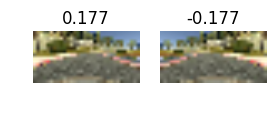

In [11]:
### Randomly choose and display from center camera images before and after flipping
random_image = random.randint(0,l_center)
unflipped_image = round(y_train_center[random_image],3)

fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(1,2,1)
ax.set_title(unflipped_image)
plt.imshow(X_train_center[random_image])
plt.axis('off')

flipped_image = round(y_train_center[l_center + random_image],3)
ax=fig.add_subplot(1,2,2)
ax.set_title(flipped_image)
plt.imshow(X_train_center[l_center + random_image])
plt.axis('off')

In [12]:
### Consolidate as one augmented training set

X_train_aug = np.append(X_train_center,np.append(X_train_left,X_train_right,axis=0),axis=0)
y_train_aug = np.append(y_train_center,np.append(y_train_left,y_train_right,axis=0),axis=0)

print("dimension of X_train_aug:{} ".format(X_train_aug.shape))
print("dimension of y_train_aug:{} ".format(y_train_aug.shape))

dimension of X_train_aug:(32144, 16, 32, 3) 
dimension of y_train_aug:(32144,) 


# Brightness Augmentation
**   To train the model to tackle varying light conditions**

In [13]:
### Brightness  augmentation for all images results in augmentaion of images by factor of 2

X_train_aug_bright=[]

### Brightness routine adapted from Vivek Yadav's blog
### https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9
    
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image.astype("uint8"),cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

for i in range(len(X_train_aug)):
    X_train_aug_bright.append(augment_brightness_camera_images(X_train_aug[i]))


X_train_aug = np.append(X_train_aug,X_train_aug_bright,axis=0)
y_train_aug = np.append(y_train_aug,y_train_aug,axis=0)



# Visualizing the Brightness augmented image

(-0.5, 31.5, 15.5, -0.5)

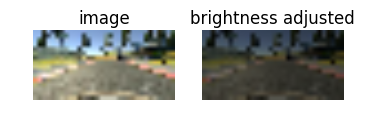

In [16]:
l_train_aug = int(len(X_train_aug)/2)

fig=plt.figure(figsize=(4,4))
### Randomly choose and display before brigtness and after brightness augmentation
ax=fig.add_subplot(1,2,1)
ax.set_title('image')
random_image = random.randint(0,l_train_aug)
plt.imshow(X_train_aug[random_image])
plt.axis('off')

ax=fig.add_subplot(1,2,2)
ax.set_title('brightness adjusted')
plt.imshow(X_train_aug[l_train_aug + random_image])
plt.axis('off')

# RGB to  HSV color space 
**Separates color component
from the luminance component, making the histogram
less sensitive to illumination changes. The 'saturation component' is fed as input to DNN as training dataset**

In [17]:
### RGB ----> HSV color space conversion

for i in range(len(X_train_aug)):
    X_train_aug[i] = cv2.cvtColor(X_train_aug[i].astype("uint8"), cv2.COLOR_RGB2HSV)

print("dimension of X_train_aug:{} ".format(X_train_aug.shape))
print("dimension of y_train_aug:{} ".format(y_train_aug.shape))

dimension of X_train_aug:(64288, 16, 32, 3) 
dimension of y_train_aug:(64288,) 


# Visualizing the S channel of HSV color space

(-0.5, 31.5, 15.5, -0.5)

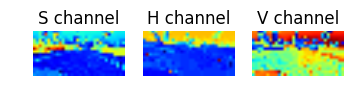

In [22]:
random_image = random.randint(0,len(X_train_aug))
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(1,3,1)
ax.set_title('S channel')
plt.imshow(X_train_aug[random_image,:,:,1])
plt.axis('off')
ax=fig.add_subplot(1,3,2)
ax.set_title('H channel')
plt.imshow(X_train_aug[random_image,:,:,0])
plt.axis('off')
ax=fig.add_subplot(1,3,3)
ax.set_title('V channel')
plt.imshow(X_train_aug[random_image,:,:,2])
plt.axis('off')

In [23]:
from sklearn.utils import shuffle

### Taking only Saturation component of HSV as training dataset and shuffled

X_train,y_train = shuffle(X_train_aug[:,:,:,1],y_train_aug)
print("dimension of X_train:{} ".format(X_train.shape))


dimension of X_train:(64288, 16, 32) 


# Histogram of Training data after augmentation

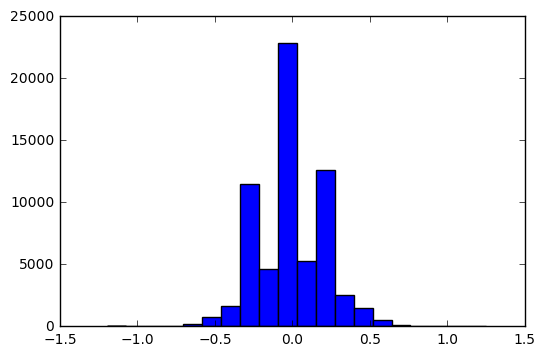

straight_steers:17444        left_steers:23366     right_steers:23478       Total samples:64288


In [24]:
plt.hist(y_train,bins=20)
plt.show()

straight_steers = len( np.where(y_train == 0.0)[0])
left_steers = len(np.where(y_train < 0.0)[0])
right_steers = len(np.where(y_train > 0.0)[0])

print("straight_steers:{0}        left_steers:{1}     right_steers:{2}       Total samples:{3}"
      .format(straight_steers,left_steers, right_steers,len(y_train)))

In [20]:
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.regularizers import l2, activity_l2

ch, row, col = 1, 16, 32  # camera format
X_train = X_train.reshape(X_train.shape[0], row, col, ch)

model = Sequential() 

model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=( row, col,ch),output_shape=(row, col,ch)))
model.add(Convolution2D(12, 3, 3, border_mode="valid"))
model.add(ELU())
model.add(MaxPooling2D((4,4),(4,4),'valid'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train, y_train, batch_size=128, nb_epoch=10, validation_split=0.2,shuffle=True)
model.summary()

Train on 51430 samples, validate on 12858 samples
Epoch 1/10
51430/51430 [==============================] - 16s - loss: 0.0596 - val_loss: 0.0273
Epoch 2/10
51430/51430 [==============================] - 17s - loss: 0.0292 - val_loss: 0.0247
Epoch 3/10
51430/51430 [==============================] - 17s - loss: 0.0262 - val_loss: 0.0238
Epoch 4/10
51430/51430 [==============================] - 17s - loss: 0.0249 - val_loss: 0.0233
Epoch 5/10
51430/51430 [==============================] - 17s - loss: 0.0241 - val_loss: 0.0232
Epoch 6/10
51430/51430 [==============================] - 17s - loss: 0.0238 - val_loss: 0.0227
Epoch 7/10
51430/51430 [==============================] - 17s - loss: 0.0235 - val_loss: 0.0226
Epoch 8/10
51430/51430 [==============================] - 17s - loss: 0.0233 - val_loss: 0.0224
Epoch 9/10
51430/51430 [==============================] - 17s - loss: 0.0233 - val_loss: 0.0225
Epoch 10/10
51430/51430 [==============================] - 17s - loss: 0.0231 - val_lo

In [21]:

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [25]:
from keras.models import model_from_json

with open("model.json", "r") as json_file:
    model = model_from_json(json_file.read())

model.compile("adam", "mse")
weights_file = "model.h5"
model.load_weights(weights_file)

In [26]:
model.get_config()


[{'class_name': 'Lambda',
  'config': {'arguments': {},
   'batch_input_shape': (None, 16, 32, 1),
   'function': ('ã\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00C\x00\x00\x00s\x0c\x00\x00\x00|\x00\x00d\x01\x00\x1bd\x02\x00\x18S)\x03Ng\x00\x00\x00\x00\x00à_@g\x00\x00\x00\x00\x00\x00ð?©\x00)\x01Ú\x01xr\x01\x00\x00\x00r\x01\x00\x00\x00ú\x14C:/SDCND_P3/model.pyÚ\x08<lambda>{\x00\x00\x00ó\x00\x00\x00\x00',
    None,
    None),
   'function_type': 'lambda',
   'input_dtype': 'float32',
   'name': 'lambda_1',
   'output_shape': (16, 32, 1),
   'output_shape_type': 'raw',
   'trainable': True}},
 {'class_name': 'Convolution2D',
  'config': {'W_constraint': None,
   'W_regularizer': None,
   'activation': 'linear',
   'activity_regularizer': None,
   'b_constraint': None,
   'b_regularizer': None,
   'bias': True,
   'border_mode': 'valid',
   'dim_ordering': 'tf',
   'init': 'glorot_uniform',
   'name': 'convolution2d_1',
   'nb_col': 3,
   'nb_filter': 12,
   'nb_row': 3,


In [27]:
model.layers[0]

In [28]:
model.layers[1]

In [29]:
model.layers[2]

In [30]:
model.layers[3]

In [31]:
model.layers[4]

In [32]:
model.layers[5]

In [33]:
model.layers[6]

(1, 16, 32, 1)


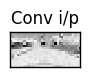

In [46]:
from keras import backend as K
import matplotlib

X = X_train[0].reshape(1,16,32,1)
# with a Sequential model
# Lambda layer(first layer) output
get_1st_layer_output = K.function([model.layers[0].input],
                                  [model.layers[0].output])
layer_lamda_output = get_1st_layer_output([X])[0]
print(layer_lamda_output.shape)
layer_lamda_output = layer_lamda_output.squeeze()
fig = plt.figure(figsize=(1,1))
ax= fig.add_subplot(1,1,1)
ax.matshow(layer_lamda_output[:,:],cmap=matplotlib.cm.binary)
ax.set_title('Conv i/p')
#ax.imshow(layer_output[:,:,i])
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.tight_layout()

(1, 14, 30, 12)


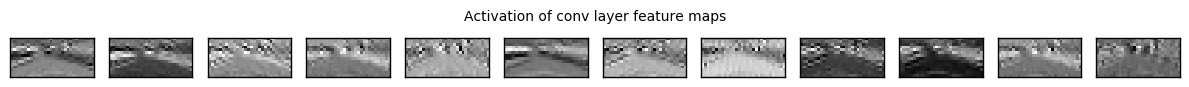

In [71]:

# with a Sequential model
# Conv layer (second layer) output
get_2nd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])
layer_Conv_output = get_2nd_layer_output([X])[0]
print(layer_Conv_output.shape)
layer_Conv_output = layer_Conv_output.squeeze()
fig = plt.figure(figsize=(12,1))
filters = 12
for i in range(12):
    ax= fig.add_subplot(1,12,i+1)
    ax.matshow(layer_Conv_output[:,:,i],cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
fig.suptitle('Activation of conv layer feature maps')

(1, 14, 30, 12)


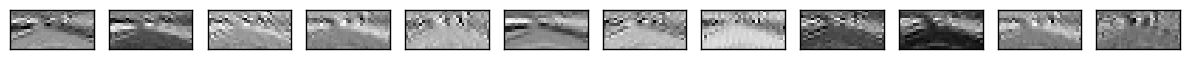

In [55]:
# with a Sequential model
# ELU activation (3rd layer) output
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_ELU_output = get_3rd_layer_output([X])[0]
print(layer_ELU_output.shape)
layer_ELU_output = layer_ELU_output.squeeze()
fig = plt.figure(figsize=(12,12))
filters = 12

for i in range(12):
    ax= fig.add_subplot(1,12,i+1)
    ax.matshow(layer_ELU_output[:,:,i],cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()

(1, 3, 7, 12)


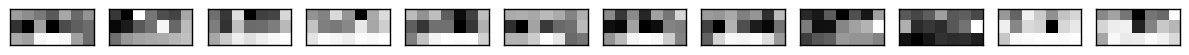

In [56]:
# with a Sequential model
# Maxpooling (4th layer) output
get_4th_layer_output = K.function([model.layers[0].input],
                                  [model.layers[3].output])
layer_MaxPool_output = get_4th_layer_output([X])[0]
print(layer_MaxPool_output.shape)
layer_MaxPool_output = layer_MaxPool_output.squeeze()
fig = plt.figure(figsize=(12,12))
filters = 12
#y = 14
#x = 30
for i in range(12):
    ax= fig.add_subplot(1,12,i+1)
    ax.matshow(layer_MaxPool_output[:,:,i],cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()

(1, 3, 7, 12)


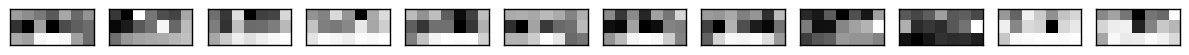

In [57]:
get_Dropout_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[4].output])

# output in test mode = 0
layer_Dropout_output = get_Dropout_layer_output([X, 0])[0]
print(layer_Dropout_output.shape)
layer_Dropout_output = layer_Dropout_output.squeeze()
fig = plt.figure(figsize=(12,12))
filters = 12

for i in range(12):
    ax= fig.add_subplot(1,12,i+1)
    ax.matshow(layer_Dropout_output[:,:,i],cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()

# output in train mode = 1
#layer_output = get_3rd_layer_output([X, 1])[0]